In [2]:
%matplotlib qt
import matplotlib
# matplotlib.use('macosx')
import mne
import numpy as np
import matplotlib.pyplot as plt
import os.path as op
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
import warnings
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

mne.set_log_level('WARNING')
warnings.simplefilter("ignore", category=DeprecationWarning)

In [3]:
def my_var_cut_fn(epochs, plow, phigh, to_plot=True):
    """
    Variance based trial rejection function
    """
    trl_var, trlindx = np.empty((0,1),'float'), np.arange(0,len(epochs))
    for trnum in range(len(epochs)):
        trl_var = np.vstack((trl_var, max(np.var(np.squeeze(epochs[trnum].get_data()), axis=1))))
    lim1 = (trl_var < np.percentile(trl_var, plow, interpolation='midpoint')).flatten()
    lim2 = (trl_var > np.percentile(trl_var, phigh, interpolation='midpoint')).flatten()
    outlr_idx = trlindx[lim1].tolist() + trlindx[lim2].tolist()
    
    if to_plot:
        plt.figure(), plt.scatter(trlindx, trl_var, marker='o', s=50, c='g', label='Good trials'),
        plt.ylabel('Max. variance across channels-->')
        plt.scatter(outlr_idx, trl_var[outlr_idx], marker='o', s=50, c='r', label='Variance based bad trials'),
        plt.xlabel('Trial number-->')
        plt.scatter(badtrls, trl_var[badtrls], marker='o', s=50, c='orange', label='Manually assigned bad trials')
        plt.ylim(min(trl_var)-min(trl_var)*0.01, max(trl_var)+max(trl_var)*0.01), plt.title('Max. variance distribution')
        plt.legend()
        plt.show()
    bad_trials = np.union1d(badtrls, outlr_idx)
    print('Removed trials: %s\n'%bad_trials)
    return bad_trials

In [5]:
#%% Set parameters, directories and filenames
iSub = 8
more_plots = True

par = {'ctrlwin': [-0.5, 0], 'actiwin': [0, 1]}
badtrls, plow, phigh = [], 2.0, 98.0

data_dir = op.expanduser("~/data/pic-name-data-bids/")
sSub, session, task, run = '%02d'%iSub, '01', 'picturenaming', '01'

data_path = op.join(data_dir, 'MEG')
subjects_dir = op.join(data_dir, 'MRI')
subject = 'sub-' + sSub
res_dir = op.join(op.expanduser("~/research/results/picname"), subject)

In [6]:
bids_fname = subject + '_ses-' + session + '_task-' + task + '_run-' + run + '_meg.fif'
bids_path = op.join(data_path, subject, 'ses-'+session, 'meg')

In [7]:
# bids_fname = bids_basename + '_meg.fif'
# bids_path = op.join(data_path, subject, 'ses-'+session, 'meg')

raw_fname = op.join(bids_path, bids_fname)
trans_fname = op.join(bids_path, subject+'-trans.fif')
fwd_fname = op.join(bids_path, subject + '-vol-meg-fwd.fif')

print(raw_fname)
print(trans_fname)
print(fwd_fname)

/home/anakin/data/pic-name-data-bids/MEG/sub-08/ses-01/meg/sub-08_ses-01_task-picturenaming_run-01_meg.fif
/home/anakin/data/pic-name-data-bids/MEG/sub-08/ses-01/meg/sub-08-trans.fif
/home/anakin/data/pic-name-data-bids/MEG/sub-08/ses-01/meg/sub-08-vol-meg-fwd.fif


In [8]:
raw = mne.io.read_raw_fif(raw_fname, allow_maxshield=False, preload=True, verbose=True)

Opening raw data file /home/anakin/data/pic-name-data-bids/MEG/sub-08/ses-01/meg/sub-08_ses-01_task-picturenaming_run-01_meg.fif...
    Range : 25000 ... 597999 =     25.000 ...   597.999 secs
Ready.
Reading 0 ... 572999  =      0.000 ...   572.999 secs...


In [ ]:
# raw.info

In [ ]:
# mne.bem.make_watershed_bem(subject, subjects_dir)

In [ ]:
# to_drop = ['STI201', 'STI301', 'CHPI001', 'CHPI002', 'CHPI003', 'CHPI004', 'CHPI005', 'CHPI006',
#            'CHPI007', 'CHPI008', 'CHPI009']
# raw.drop_channels(to_drop)

In [ ]:
# raw.plot();

In [ ]:
# raw.annotations.save(data_path + subject +'/annot.csv')

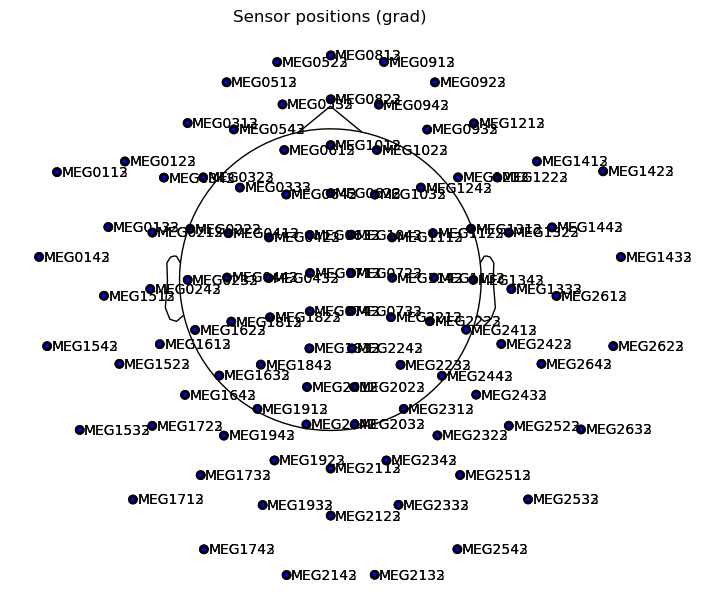

In [28]:
raw.plot_sensors(ch_type='grad', show_names=True)

In [26]:
events = mne.find_events(raw, stim_channel='STI101',
                                  min_duration=0.001, shortest_event=1)

In [23]:
# event_id = events[:, 2].tolist()
# event_id

In [27]:
events

array([[ 91998,      0,      6],
       [ 96748,      0,     40],
       [101480,      0,      2],
       [106239,      0,     54],
       [111002,      0,     56],
       [115744,      0,     58],
       [120493,      0,      9],
       [125255,      0,     21],
       [130009,      0,     10],
       [134807,      0,     26],
       [139573,      0,     11],
       [144322,      0,      8],
       [149047,      0,     50],
       [153815,      0,     16],
       [158555,      0,     47],
       [163344,      0,     17],
       [168101,      0,     33],
       [172865,      0,     35],
       [177587,      0,     23],
       [182312,      0,      1],
       [187116,      0,      5],
       [191940,      0,     34],
       [196696,      0,     27],
       [201430,      0,     44],
       [206231,      0,      4],
       [211019,      0,     43],
       [215776,      0,     19],
       [220510,      0,     53],
       [225315,      0,     20],
       [230082,      0,     29],
       [23

In [24]:
int(0.056 * raw.info['sfreq'])

56

In [25]:
delay = int(round(0.056 * raw.info['sfreq']))
events[:, 0] = events[:, 0] + delay
events

array([[ 92054,      0,      6],
       [ 96804,      0,     40],
       [101536,      0,      2],
       [106295,      0,     54],
       [111058,      0,     56],
       [115800,      0,     58],
       [120549,      0,      9],
       [125311,      0,     21],
       [130065,      0,     10],
       [134863,      0,     26],
       [139629,      0,     11],
       [144378,      0,      8],
       [149103,      0,     50],
       [153871,      0,     16],
       [158611,      0,     47],
       [163400,      0,     17],
       [168157,      0,     33],
       [172921,      0,     35],
       [177643,      0,     23],
       [182368,      0,      1],
       [187172,      0,      5],
       [191996,      0,     34],
       [196752,      0,     27],
       [201486,      0,     44],
       [206287,      0,      4],
       [211075,      0,     43],
       [215832,      0,     19],
       [220566,      0,     53],
       [225371,      0,     20],
       [230138,      0,     29],
       [23

In [ ]:
if more_plots:
    mne.viz.plot_events(events, first_samp=0, event_id=None,
                       equal_spacing=True, show=True)

In [29]:
picks = mne.pick_types(raw.info, meg=True, eog=True, ecg=True, stim=False, exclude='bads')

In [30]:
#%% Apply filter if required
raw.filter(2, 40, picks=picks, filter_length='auto', n_jobs=1,
          method='fir', iir_params=None, phase='zero', fir_window='hamming',
          fir_design='firwin', skip_by_annotation=('edge', 'bad_acq_skip'),
          pad='reflect_limited', verbose=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 sec)



<Raw | sub-08_ses-01_task-picturenaming_run-01_meg.fif, 320 x 573000 (573.0 s), ~1.37 GB, data loaded>

In [ ]:
if more_plots:
    raw.plot_psd(fmin=0, fmax=45, proj=False, verbose=True)

In [31]:
epochs = mne.Epochs(raw, events, event_id=None, tmin=-0.5, tmax=1.0,
                   baseline=(-0.5,0), picks=picks, preload=True,
                   reject=None, flat=None, proj=False, decim=1,
                   reject_tmin=None, reject_tmax=None, detrend=None,
                   on_missing='error', reject_by_annotation=True,
                   verbose=True)

Not setting metadata
Not setting metadata
104 matching events found
Applying baseline correction (mode: mean)
Loading data for 104 events and 1501 original time points ...
0 bad epochs dropped


In [ ]:
# eog_epochs = mne.preprocessing.create_eog_epochs(raw.copy().filter(1, None))
# eog_epochs.average().plot_joint()
# ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
# ecg_epochs.average().plot_joint()

In [32]:
#% % Find trial variance > index outliers
epochs.pick_types(meg=True)
bad_trials = my_var_cut_fn(epochs, plow, phigh, to_plot=False)
epochs.drop(bad_trials, reason='variance based rejection', verbose=True)
bad_trials = []

Removed trials: [ 11.  19.  24.  29.  72. 101.]

Dropped 6 epochs: 11.0, 19.0, 24.0, 29.0, 72.0, 101.0


In [ ]:
# epochs.average().plot(spatial_colors=True, gfp=True, time_unit='ms')

In [ ]:
# layouts = [mne.find_layout(raw.info, ch_type=ch) for ch in ("mag", "grad")]
# if subject in ['sub-02']:
#     print('Applying EOG projector for', subject)
#     projs_eog, _ = mne.preprocessing.compute_proj_eog(raw, n_mag=3, n_grad=3)
#     mne.viz.plot_projs_topomap(projs_eog, raw.info, layout=layouts);
#     print('Applying ECG projector for', subject)
#     projs_ecg, _ = mne.preprocessing.compute_proj_ecg(raw, n_mag=3, n_grad=3)
#     mne.viz.plot_projs_topomap(projs_ecg, raw.info, layout=layouts);
# else:
#     print('Applying EOG projector for', subject)
#     projs_eog, _ = mne.preprocessing.compute_proj_eog(raw, n_mag=3, n_grad=3)
#     mne.viz.plot_projs_topomap(projs_eog, raw.info, layout=layouts);
#     projs_ecg = []

In [ ]:
# evoked = epochs.average()
# evoked.del_proj() # delete previous proj
# #% take first projector for each sensor type
# if subject in ['sub-02']:
#     evoked.add_proj(projs_eog[::3] + projs_ecg[::3])
# else:
#     evoked.add_proj(projs_eog[::3])
# evoked.apply_proj() # apply
# evoked.plot(spatial_colors=True, gfp=True, proj=False, time_unit='ms')

In [ ]:
# epochs.del_proj()
# epochs.add_proj(projs_eog[::3])

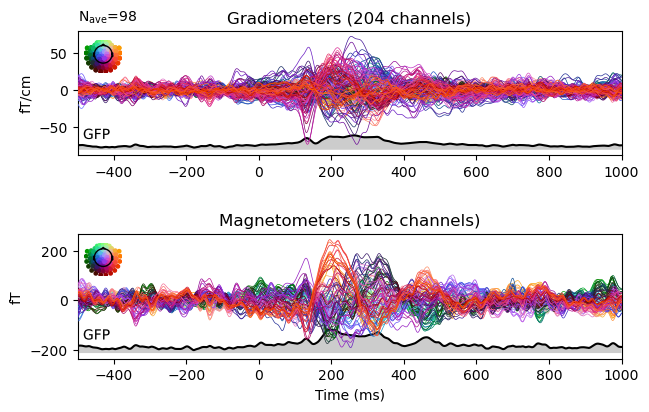

In [33]:
evoked = epochs.average()
evoked.plot(spatial_colors=True, gfp=True, proj=False, time_unit='ms')
# plt.savefig(op.join(res_dir, 'evoked_' + subject + '.pdf'))

In [ ]:
epochs_fname = op.join(bids_path, bids_fname.replace('_meg.fif', '-epo.fif'))
epochs.save(epochs_fname, overwrite=True)

In [ ]:
# epochs.apply_proj()

In [ ]:
# evoked = epochs.average()

In [38]:
grad_vis = ['MEG1943', 'MEG1923', 'MEG2113', 'MEG2343']
for inx, name in enumerate(epochs.ch_names):
    if name in grad_vis:
        print("%s is channel # %d" % (name, inx))

MEG1923 is channel # 213
MEG1943 is channel # 219
MEG2113 is channel # 234
MEG2343 is channel # 267


In [39]:
epochs.plot_image(picks=[213, 219, 234, 267], sigma=1);
# plt.savefig(op.join(res_dir, 'epochs_MEG2343_' + subject + '.pdf'))

In [ ]:
times = [0.2, 0.4] # Highly data dependent
evoked.plot_joint(times=times, picks='mag');
# plt.savefig(op.join(res_dir, 'evoked_joint_plot' + subject + '.pdf'))

In [ ]:
evoked.plot_topomap(times=np.linspace(0.1, 0.4, 7), ch_type='mag');
# plt.savefig(op.join(res_dir, 'evoked_topomap_mag_' + subject + '.pdf'))

In [ ]:
epochs.plot_psd_topomap(ch_type='mag', normalize=True, cmap='viridis');
# plt.savefig(op.join(res_dir, 'psd_topomap_mag_' + subject + '.pdf'))

epochs.plot_psd_topomap(ch_type='grad', normalize=True, cmap='viridis');
# plt.savefig(op.join(res_dir, 'psd_topomap_grad_' + subject + '.pdf'))

In [ ]:
plt.close('all')

In [ ]:
freqs = np.logspace(*np.log10([2, 30]), num=20)
n_cycles = freqs / 2.
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                       return_itc=True, decim=3, n_jobs=1)

power.crop(-0.1, 0.8)
itc.crop(-0.1, 0.8)
baseline_mode = 'logratio'
baseline = (None, 0)

In [ ]:
# for inx, name in enumerate(epochs.ch_names):
#     if name == 'MEG2343':
#         print("MEG 2343 is channel #", inx)

In [ ]:
power.plot([267], baseline=baseline, mode=baseline_mode);
# plt.savefig(op.join(res_dir, 'power_MEG2343_' + subject + '.pdf'))

In [ ]:
fig, axis = plt.subplots(1, 3, figsize=(7, 4))
power.plot_topomap(ch_type='grad', tmin=0., tmax=0.6, fmin=4, fmax=7,
                  baseline=baseline, mode=baseline_mode, axes=axis[0],
                  title='Theta', show=False, contours=1)
power.plot_topomap(ch_type='grad', tmin=0., tmax=0.6, fmin=8, fmax=12,
                  baseline=baseline, mode=baseline_mode, axes=axis[1],
                  title='Alpha', show=False, contours=1)
power.plot_topomap(ch_type='grad', tmin=0., tmax=0.6, fmin=15, fmax=30,
                  baseline=baseline, mode=baseline_mode, axes=axis[2],
                  title='Beta', show=False, contours=1)
mne.viz.tight_layout()
plt.show()

# plt.savefig(op.join(res_dir, 'power_topomap_t=0-0p6_' + subject + '.pdf'))

In [ ]:
itc.plot([267], baseline=baseline, mode=baseline_mode);
# plt.savefig(op.join(res_dir, 'itc_MEG2343_' + subject + '.pdf'))

In [ ]:
itc.plot_topomap(ch_type='mag', tmin=0.1, tmax=0.3, fmin=3.5, fmax=7.,
                baseline=baseline, mode='mean', size=6)
mne.viz.tight_layout()
# plt.savefig(op.join(res_dir, 'itc_topomap_' + subject + '.pdf'))

In [ ]:
plt.close('all')

In [ ]:
mrifile = op.join(subjects_dir, subject, 'mri/T1.mgz')
surffile = op.join(subjects_dir, subject, 'bem/watershed', 'sub-01_brain_surface')
src_vol = mne.setup_volume_source_space(subject=subject, pos=5.0,
            mri=mrifile, bem=None, surface=surffile, mindist=2.5,
            exclude=10, subjects_dir=subjects_dir, volume_label=None,
            add_interpolator=None, verbose=True)

In [ ]:
info = mne.io.read_info(raw_fname)
# mne.viz.plot_alignment(info, trans_fname, subject=subject,
#                       src=src_vol, subjects_dir=subjects_dir, dig=True,
#                       surfaces=['head', 'white'], coord_frame='meg', meg=False)

In [ ]:
model = mne.make_bem_model(subject=subject, ico=4, conductivity=(0.33,),
            subjects_dir=subjects_dir, verbose=True)

In [ ]:
bem = mne.make_bem_solution(model)

In [ ]:
bem_fname = op.join(bids_path, subject + '-grid-bem.fif')
mne.bem.write_bem_solution(bem_fname, bem, overwrite=True)

In [ ]:
fwd = mne.make_forward_solution(evoked.info, trans=trans_fname, src=src_vol,
        bem=bem, meg=True, eeg=False, mindist=2.5, n_jobs=1)
print("Leadfield size : %d sensors x %d dipoles" % fwd['sol']['data'].shape)

In [ ]:
# fwd_fname = op.join(bids_path, subject + '-vol-meg-fwd.fif')
mne.write_forward_solution(fwd_fname, fwd, overwrite=True)

In [ ]:
# Compute covariance
noise_cov = mne.compute_covariance(epochs,
                tmin=par['ctrlwin'][0], tmax=par['ctrlwin'][1],
                method='empirical', rank='info', verbose=True)

data_cov = mne.compute_covariance(epochs,
                tmin=par['actiwin'][0], tmax=par['actiwin'][1],
                method='empirical', rank='info', verbose=True)

In [ ]:
# mne.viz.plot_cov(noise_cov, epochs.info)

In [ ]:
evoked.plot_white(noise_cov);
# plt.savefig(op.join(res_dir, 'evoked_plot_white_' + subject + '.pdf'))

In [ ]:
# Compute inverse
inverse_operator = mne.minimum_norm.make_inverse_operator(info, 
    fwd, noise_cov, rank=None, loose=1, depth=0.199, verbose=True)

In [ ]:
# Compute SNR
snr, _ = mne.minimum_norm.estimate_snr(evoked, inverse_operator, verbose=True)
nt_snr = np.argmax(snr)
SNR = snr[nt_snr]
print('\nMax SNR at %0.3f s : %0.3f' % (evoked.times[nt_snr], SNR))

In [ ]:
# Compute filter and output
filters = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,
            noise_cov=noise_cov, pick_ori='max-power', rank=None,
            weight_norm='nai', reduce_rank=True, verbose=True)

stc = mne.beamformer.apply_lcmv(evoked, filters, max_ori_out='signed', verbose=True)

In [ ]:
stc_fname = op.join(res_dir, 'lcmv_' + subject)
stc.save(stc_fname)

In [ ]:
stc = np.abs(stc)

In [ ]:
_, t_peak = stc.get_peak()
print('Source peaked at = %0.3f' % t_peak)
nt_src_peak = int(t_peak//stc.tstep - stc.times[0]//stc.tstep)

In [ ]:
img = stc.as_volume(fwd['src'], dest='mri', mri_resolution=False, format='nifti1')

In [ ]:
plot_stat_map(index_img(img, nt_src_peak), mrifile, threshold=stc.data.max()*0.70)
# plt.savefig(op.join(res_dir,
#         'stat_map_' + 'time=%0.3fs_'%(stc.times[nt_src_peak]) + subject + '.pdf'))

In [ ]:
plt.show()

In [ ]:
plot_stat_map(index_img(img, nt_snr), mrifile, threshold=stc.data.max()*0.30)
# plt.savefig(op.join(res_dir,
#         'stat_map_' + 'time=%0.3fs_'%(stc.times[nt_snr]) + subject + '.pdf'))

In [ ]:
plt.show()

In [ ]:
plt.close('all')